In [699]:
import pandas as pd
import torch
import torch.nn as nn
import numpy as np
import os
from glicko2 import Player
from helpers import davidson_mov
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import f1_score, precision_score, recall_score
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, LSTM, Dense, Concatenate
from tensorflow.keras.models import Model


In [700]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [701]:
df_engineered = pd.read_csv('EPL_ENGINEERED.CSV')
df = pd.read_csv('GLICKO.csv')

In [702]:
# Combine the two DataFrames side by side using their indice
df = pd.concat([df, df_engineered], axis=1)



In [703]:

df.rename(columns = {
    'AwayTeamGlickoRating': 'awayGlickoRating',
    'AwayTeamGlickoUpper': 'awayGlickoUpper',
    'AwayTeamGlickoLower': 'awayGlickoLower',
    'HomeTeamGlickoRating': 'homeGlickoRating',
    'HomeTeamGlickoUpper': 'homeGlickoUpper',
    'HomeTeamGlickoLower': 'homeGlickoLower',
},inplace=True)
df.drop(columns = ['TTG','time','AwayTeamGlickoRD','HomeTeamGlickoRD'],inplace=True)


In [704]:
import pandas as pd

def split_matches_with_id(df):
    """
    Splits each match into two perspectives: home team and away team.
    Ensures that for each match, the two resulting rows are consecutive.
    
    Args:
        df (pd.DataFrame): Original DataFrame containing match data.
    
    Returns:
        pd.DataFrame: New DataFrame with separate rows for home and away perspectives.
    """
    # Assign a unique match identifier
    df = df.copy().reset_index(drop=True)
    df['match_id'] = df.index  # Simple unique identifier; modify if needed

    # Identify all 'home' and 'away' prefixed columns
    home_cols = [col for col in df.columns if col.startswith('home')]
    away_cols = [col for col in df.columns if col.startswith('away')]

    # Columns that are not prefixed with 'home' or 'away' or 'match_id'
    common_cols = [col for col in df.columns if not (col.startswith('home') or col.startswith('away'))]

    # Initialize list to store new rows
    new_rows = []

    # Iterate over each row in the DataFrame
    for idx, row in df.iterrows():
        # --------------------
        # Home Team Perspective
        # --------------------
        home_row = {}

        # Assign match_id, team, and opponent
        home_row['match_id'] = row['match_id']
        home_row['date'] = row['date']
        home_row['team'] = row['homeTeam']
        home_row['opponent'] = row['awayTeam']
        home_row['goalsScored'] = row['homeScore']
        home_row['goalsConceded'] = row['awayScore']
        home_row['is_home'] = 1
        
        # Assuming FTR: 0 = Home Win, 1 = Draw, 2 = Away Win
        if row['FTR'] == 0:
            home_row['FTR'] = 0  # Home Win
        elif row['FTR'] == 1:
            home_row['FTR'] = 1
        else:
            home_row['FTR'] = 2
            
            


        # Add 'team_' prefixed columns (remove 'home' prefix)
        for col in home_cols:
            new_col = col.replace('home', '').strip('_')  # e.g., 'attack'
            home_row[f'team_{new_col}'] = row[col]

        # Add 'opp_' prefixed columns from 'away' columns (remove 'away' prefix)
        for col in away_cols:
            new_col = col.replace('away', '').strip('_')  # e.g., 'attack'
            home_row[f'opp_{new_col}'] = row[col]

        # --------------------
        # Away Team Perspective
        # --------------------
        away_row = {}

        # Assign match_id, team, and opponent
        away_row['match_id'] = row['match_id']
        away_row['date']  = row['date']
        away_row['team'] = row['awayTeam']
        away_row['opponent'] = row['homeTeam']
        away_row['goalsScored'] = row['awayScore']
        away_row['goalsConceded'] = row['homeScore']
        away_row['is_home'] = 0

        # Handle 'FTR' for away perspective
        # From away perspective: 2 = Away Win => 1, else 0
        if row['FTR'] == 2:
            away_row['FTR'] = 0  # Away Win
        elif row['FTR'] == 1:
            away_row['FTR'] = 1
        else:
            away_row['FTR'] = 2# Draw or Home Win

        # Add 'team_' prefixed columns from 'away' columns (remove 'away' prefix)
        for col in away_cols:
            new_col = col.replace('away', '').strip('_')  # e.g., 'attack'
            away_row[f'team_{new_col}'] = row[col]

        # Add 'opp_' prefixed columns from 'home' columns (remove 'home' prefix)
        for col in home_cols:
            new_col = col.replace('home', '').strip('_')  # e.g., 'attack'
            # If the column represents differences, invert the sign
            if col in ['homeGlickoDiff', 'homeGlickoUpperDiff', 'homeGlickoLowerDiff']:
                away_row[f'opp_{new_col}'] = -row[col]
            else:
                away_row[f'opp_{new_col}'] = row[col]

        # Append both home and away rows to new_rows list
        new_rows.extend([home_row, away_row])

    # Create a new dataframe from the list of new rows
    new_df = pd.DataFrame(new_rows)

    new_df.reset_index(drop=True, inplace=True)

    # Optionally, drop 'match_id' if not needed further
    # new_df.drop('match_id', axis=1, inplace=True)

    return new_df


In [705]:
new_df = split_matches_with_id(df)
new_df.drop(columns=['team_Team','team_Score','opp_Score'],inplace=True)
new_df['glickoDiff'] = new_df['team_GlickoRating'] - new_df['opp_GlickoRating']
new_df['glickoDiffUpper'] = new_df['team_GlickoUpper'] - new_df['opp_GlickoUpper']
new_df['glickoDiffLower'] = new_df['team_GlickoLower'] - new_df['opp_GlickoLower']

In [706]:
# Attack Difference
new_df['diff_Attack'] = new_df['team_Attack'] - new_df['opp_Attack']

# Defence Difference
new_df['diff_Defence'] = new_df['team_Defence'] - new_df['opp_Defence']

new_df['diff_goals'] = new_df['goalsScored'] - new_df['goalsConceded']

# Pass Power Difference
new_df['diff_PassPower'] = new_df['team_PassPower'] - new_df['opp_PassPower']

# Box Presence Difference
new_df['diff_BoxPresence'] = new_df['team_BoxPresence'] - new_df['opp_BoxPresence']

# Ground Duel Percent Difference
new_df['diff_groundDuelPercent'] = new_df['team_groundDuelPercent'] - new_df['opp_groundDuelPercent']

# Aerial Duel Percent Difference
new_df['diff_aerialDuelPercent'] = new_df['team_aerialDuelPercent'] - new_df['opp_aerialDuelPercent']

# Duel Power Difference
new_df['diff_DuelPower'] = new_df['team_DuelPower'] - new_df['opp_DuelPower']

# Possession Efficiency Difference
new_df['diff_PossessionEfficiency'] = new_df['team_PossessionEfficiency'] - new_df['opp_PossessionEfficiency']

# Final Third Efficiency Difference
new_df['diff_finalThirdEfficiency'] = new_df['team_finalThirdEfficiency'] - new_df['opp_finalThirdEfficiency']

# Foul Threat Index Difference
new_df['diff_FoulThreatIndex'] = new_df['team_FoulThreatIndex'] - new_df['opp_FoulThreatIndex']

# XGc Difference
new_df['diff_XGc'] = new_df['team_XGc'] - new_df['opp_XGc']

# ATI Difference
new_df['diff_ATI'] = new_df['team_ATI'] - new_df['opp_ATI']

# Territorial Dominance Difference
new_df['diff_TerritorialDominance'] = new_df['team_TerritorialDominance'] - new_df['opp_TerritorialDominance']

# Passing Disruption Difference
new_df['diff_PassingDisruption'] = new_df['team_PassingDisruption'] - new_df['opp_PassingDisruption']

# Transition Efficiency Difference
new_df['diff_TransitionEfficiency'] = new_df['team_TransitionEfficiency'] - new_df['opp_TransitionEfficiency']

# Won Tackle Difference
new_df['diff_wonTackle'] = new_df['team_wonTackle'] - new_df['opp_wonTackle']

# Pressure Index Difference
new_df['diff_PressureIndex'] = new_df['team_PressureIndex'] - new_df['opp_PressureIndex']

# xDS Difference
new_df['diff_xDS'] = new_df['team_xDS'] - new_df['opp_xDS']

# Discipline Difference
new_df['diff_Discipline'] = new_df['team_Discipline'] - new_df['opp_Discipline']

In [707]:
from sklearn.preprocessing import StandardScaler
import pandas as pd

# Create a StandardScaler instance
scaler = StandardScaler()
# Extract columns to scale
columns_to_scale = ['team_Attack', 'team_Defence', 'team_GlickoRating', 'team_GlickoLower', 'team_GlickoUpper',
                    'team_PassPower', 'team_BoxPresence', 'team_groundDuelPercent', 'team_aerialDuelPercent',
                    'team_DuelPower', 'team_PossessionEfficiency', 'team_finalThirdEfficiency', 
                    'team_FoulThreatIndex', 'team_XGc', 'team_ATI', 'team_TerritorialDominance', 
                    'team_PassingDisruption', 'team_TransitionEfficiency', 'team_wonTackle', 'team_PressureIndex',
                    'team_xDS', 'team_Discipline', 'opp_Attack', 'opp_Defence', 
                    'opp_GlickoRating', 'opp_GlickoLower', 'opp_GlickoUpper', 'opp_PassPower', 
                    'opp_BoxPresence', 'opp_groundDuelPercent', 'opp_aerialDuelPercent', 'opp_DuelPower',
                    'opp_PossessionEfficiency', 'opp_finalThirdEfficiency', 'opp_FoulThreatIndex', 
                    'opp_XGc', 'opp_ATI', 'opp_TerritorialDominance', 'opp_PassingDisruption', 
                    'opp_TransitionEfficiency', 'opp_wonTackle', 'opp_PressureIndex', 'opp_xDS', 
                    'opp_Discipline', 'diff_Attack', 'diff_Defence', 'diff_goals', 'diff_PassPower', 
                    'diff_BoxPresence', 'diff_groundDuelPercent', 'diff_aerialDuelPercent', 'diff_DuelPower', 
                    'diff_PossessionEfficiency', 'diff_finalThirdEfficiency', 'diff_FoulThreatIndex', 
                    'diff_XGc', 'diff_ATI', 'diff_TerritorialDominance', 'diff_PassingDisruption', 
                    'diff_TransitionEfficiency', 'diff_wonTackle', 'diff_PressureIndex', 'diff_xDS', 
                    'diff_Discipline']

# Assuming train_data and test_data are pandas DataFrames
# Fit scaler on training data
scaler.fit(new_df[columns_to_scale])

(new_df[columns_to_scale])= scaler.transform(new_df[columns_to_scale])


In [708]:
g = new_df.copy()
g.drop(columns=['match_id','date','team','opponent','goalsConceded','is_home','team_Id','opp_Id','opp_Team','goalsScored','diff_goals'],inplace=True)

In [712]:
# Suppose you want to check the first sequence for TeamA
team_name = 'Arsenal'
if team_name in data_sequences_by_team and len(data_sequences_by_team[team_name]) > 0:
    sequence = data_sequences_by_team[team_name][90]  # Get the first sequence (match) for TeamA
    print("First sequence for", team_name, ":\n", sequence)
else:
    print(f"No data found for team {team_name}")


First sequence for Arsenal :
 {'match_id': 909, 'team': 'Arsenal', 'opponent': 'Manchester United', 'historical_team': array([[ 1.        ,  0.        ,  0.        , ...,  1.71772293,
        -0.76633396,  0.51241159],
       [ 5.        ,  0.        ,  0.        , ...,  1.67694126,
         1.19581858,  2.56205797],
       [ 1.        ,  3.        ,  2.        , ...,  0.23802699,
        -0.13055349, -1.02482319],
       ...,
       [ 1.        ,  1.        ,  1.        , ..., -0.48330979,
        -0.16117157,  0.        ],
       [ 2.        ,  1.        ,  0.        , ...,  0.14766371,
        -0.25095023,  0.51241159],
       [ 4.        ,  2.        ,  0.        , ...,  0.14038496,
         1.28138971,  1.02482319]]), 'historical_opponent': array([[ 1.        ,  0.        ,  0.        , ...,  0.83782079,
         0.        ,  0.51241159],
       [ 4.        ,  2.        ,  0.        , ...,  0.17193139,
         0.03844399,  1.02482319],
       [ 3.        ,  1.        ,  0.       

Match ID: 409
Team: Arsenal
Opponent: Liverpool


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [658]:
class SoccerDataset(Dataset):
    def __init__(self, data_sequences):
        self.data_sequences = data_sequences
    def __len__(self):
        return len(self.data_sequences)

    def __getitem__(self, idx):
        seq = self.data_sequences[idx]
        historical_team = torch.tensor(seq['historical_team'], dtype=torch.float32)
        historical_opp = torch.tensor(seq['historical_opponent'], dtype=torch.float32)
        current = torch.tensor(seq['current'], dtype=torch.float32)
        target = torch.tensor(seq['target'], dtype=torch.long)
        return historical_team, historical_opp, current, target


In [ ]:
# for team, sequences in data_sequences_by_team.items():
#     for seq in sequences:
#         seq['historical_team'] = np.array(seq['historical_team'], dtype=np.float32)
#         seq['historical_opponent'] = np.array(seq['historical_opponent'], dtype=np.float32)
#         seq['current'] = np.array(seq['current'], dtype=np.float32)
#         seq['target'] = np.array(seq['target'], dtype=np.int64)


In [ ]:
# sequence = data_sequences_by_team[team_name][212]
# print("Match ID:", sequence['match_id'])
# print("Team:", sequence['team'])
# print("Opponent:", sequence['opponent'])
# print("Historical Team shape:", sequence['historical_team'].shape)
# if sequence['historical_team'].shape[0] > 0:
#     print("Number of time steps:", sequence['historical_team'].shape[0])
#     print("Number of features per timestep:", sequence['historical_team'].shape[1])
# else:
#     print("Historical Team array is empty.")

# print("Historical Team shape:", sequence['historical_opponent'].shape)
# if sequence['historical_opponent'].shape[0] > 0:
#     print("Number of time steps:", sequence['historical_opponent'].shape[0])
#     print("Number of features per timestep:", sequence['historical_opponent'].shape[1])
# else:
#     print("Historical Team array is empty.")

# print("Current features shape:", sequence['current'].shape)
# print("Target:", sequence['target'])


Match ID: 2139
Team: Arsenal
Opponent: Brentford
Historical Team shape: (40, 71)
Number of time steps: 40
Number of features per timestep: 71
Historical Team shape: (40, 71)
Number of time steps: 40
Number of features per timestep: 71
Current features shape: (14,)
Target: 0


In [ ]:
# class SoccerLSTM(nn.Module):
#     def __init__(self, historical_dim, current_dim, hidden_dim, output_dim, num_layers=1, device='cuda'):
#         super(SoccerLSTM, self).__init__()
#         self.hidden_dim = hidden_dim
#         self.num_layers = num_layers
#         self.device = torch.device(device)
        
#         # LSTMs for team and opponent historical sequences
#         self.team_lstm = nn.LSTM(historical_dim, hidden_dim, num_layers, batch_first=True)
#         self.opp_lstm = nn.LSTM(historical_dim, hidden_dim, num_layers, batch_first=True)
        
#         # Fully connected layers
#         self.fc = nn.Sequential(
#             nn.Linear(hidden_dim * 2 + current_dim, 512),  # Combine team, opponent, and current inputs
#             nn.LeakyReLU(),
#             nn.Dropout(p=0.3),
#             nn.Linear(512, 256),
#             nn.LeakyReLU(),
#             nn.Dropout(p=0.3),
#             nn.Linear(256, 128),
#             nn.LeakyReLU(),
#             nn.Dropout(p=0.2),
#             nn.Linear(128, output_dim)
#         )
        
#         self.hidden_team = None
#         self.hidden_opp = None

#     def forward(self, historical_team, historical_opp, current):
#         # Reset hidden states if needed
#         if self.hidden_team is None or self.hidden_opp is None:
#             batch_size = historical_team.size(0)
#             self.hidden_team = self.init_hidden(batch_size)
#             self.hidden_opp = self.init_hidden(batch_size)
        
#         # Detach hidden states to prevent backprop across batches
#         self.hidden_team = (self.hidden_team[0].detach(), self.hidden_team[1].detach())
#         self.hidden_opp = (self.hidden_opp[0].detach(), self.hidden_opp[1].detach())
        
#         # Process historical sequences
#         team_out, self.hidden_team = self.team_lstm(historical_team, self.hidden_team)
#         opp_out, self.hidden_opp = self.opp_lstm(historical_opp, self.hidden_opp)
        
#         # Take the last output of both LSTMs
#         team_out = team_out[:, -1, :]
#         opp_out = opp_out[:, -1, :]
        
#         # Combine with current features
#         combined = torch.cat((team_out, opp_out, current), dim=1)
#         output = self.fc(combined)

#         return output

#     def init_hidden(self, batch_size):
#         hidden = torch.zeros(self.num_layers, batch_size, self.hidden_dim).to(self.device)
#         cell = torch.zeros(self.num_layers, batch_size, self.hidden_dim).to(self.device)
#         return (hidden, cell)

#     def reset_hidden_state(self):
#         self.hidden_team = None
#         self.hidden_opp = None




In [ ]:
# from torch.optim.lr_scheduler import StepLR
# # Hyperparameters
# historical_dim = 71  # Number of features in historical sequence
# current_dim = 14     # Number of features in current match input
# hidden_dim = 128      # Hidden units in LSTM
# output_dim = 3       # Number of output classes (e.g., win, draw, lose)
# num_layers = 1       # Number of LSTM layers

# learning_rate = 0.0003
# # Model, loss, and optimizer
# model = SoccerLSTM(historical_dim, current_dim, hidden_dim, output_dim, num_layers).to(device)
# criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate,weight_decay=1e-4)

# scheduler = StepLR(optimizer,step_size = 2, gamma=0.5)  # T_max = total epochs



Epoch 1/15, Train Loss: 1.0975, Validation Loss: 1.0367, Train Accuracy: 48.37%, Validation Accuracy: 54.44%
Epoch 2/15, Train Loss: 1.0968, Validation Loss: 1.0170, Train Accuracy: 47.78%, Validation Accuracy: 55.16%
Epoch 3/15, Train Loss: 1.0380, Validation Loss: 1.0030, Train Accuracy: 51.77%, Validation Accuracy: 54.92%
Epoch 4/15, Train Loss: 1.0293, Validation Loss: 1.0048, Train Accuracy: 52.26%, Validation Accuracy: 55.08%
Epoch 5/15, Train Loss: 1.0075, Validation Loss: 0.9929, Train Accuracy: 52.78%, Validation Accuracy: 55.56%
Epoch 6/15, Train Loss: 1.0100, Validation Loss: 0.9863, Train Accuracy: 52.60%, Validation Accuracy: 55.71%
Epoch 7/15, Train Loss: 1.0005, Validation Loss: 0.9816, Train Accuracy: 52.84%, Validation Accuracy: 55.40%
Epoch 8/15, Train Loss: 1.0020, Validation Loss: 0.9866, Train Accuracy: 52.76%, Validation Accuracy: 55.40%
Epoch 9/15, Train Loss: 0.9937, Validation Loss: 0.9757, Train Accuracy: 52.90%, Validation Accuracy: 55.48%
Epoch 10/15, Train 

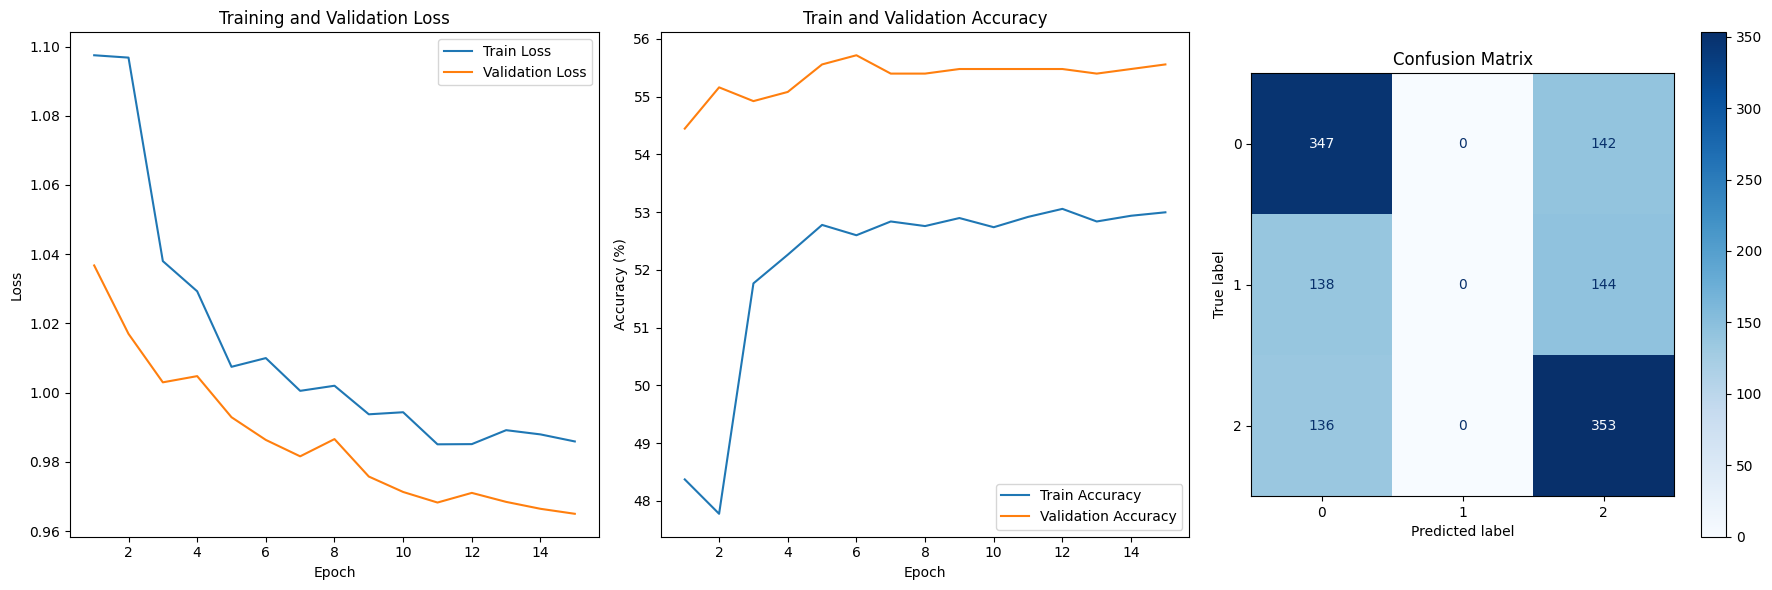

In [ ]:
# import matplotlib.pyplot as plt
# import numpy as np
# from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# epochs = 15

# # Lists to store losses and accuracies for plotting
# train_losses = []
# val_losses = []
# train_accuracies = []
# val_accuracies = []

# for epoch in range(epochs):
#     model.train()
#     model.reset_hidden_state()  # Reset hidden state at the start of each epoch
#     train_loss = 0.0
#     correct_train = 0
#     total_train = 0

#     for historical_team, historical_opp, current, target in train_loader:
#         historical_team, historical_opp, current, target = (
#             historical_team.to(device),
#             historical_opp.to(device),
#             current.to(device),
#             target.to(device)
#         )

#         # Zero gradients
#         optimizer.zero_grad()

#         # Forward pass
#         output = model(historical_team, historical_opp, current)
#         loss = criterion(output, target)

#         # Backward pass and optimization
#         loss.backward()
#         optimizer.step()


#         train_loss += loss.item()

#         # Calculate train accuracy
#         _, predicted = torch.max(output, 1)
#         total_train += target.size(0)
#         correct_train += (predicted == target).sum().item()
#     scheduler.step()
#     train_losses.append(train_loss / len(train_loader))
#     train_accuracies.append(correct_train / total_train * 100)

#     # Validation phase
#     model.eval()
#     model.reset_hidden_state()  # Reset hidden state for validation

#     val_loss = 0.0
#     correct_val = 0
#     total_val = 0
#     all_targets = []
#     all_predictions = []

#     with torch.no_grad():
#         for historical_team, historical_opp, current, target in test_loader:
#             historical_team, historical_opp, current, target = historical_team.to(device), historical_opp.to(device), current.to(device), target.to(device)

#             # Forward pass
#             output = model(historical_team, historical_opp,  current)
#             loss = criterion(output, target)
#             val_loss += loss.item()

#             _, predicted = torch.max(output, 1)

#             total_val += target.size(0)
#             correct_val += (predicted == target).sum().item()

#             # Collect all targets and predictions for confusion matrix
#             all_targets.extend(target.cpu().numpy())
#             all_predictions.extend(predicted.cpu().numpy())

#     val_losses.append(val_loss / len(test_loader))
#     val_accuracies.append(correct_val / total_val * 100)

#     print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_losses[-1]:.4f}, "
#           f"Validation Loss: {val_losses[-1]:.4f}, "
#           f"Train Accuracy: {train_accuracies[-1]:.2f}%, "
#           f"Validation Accuracy: {val_accuracies[-1]:.2f}%")

# # Plot training and validation loss, accuracies
# plt.figure(figsize=(18, 6))

# # Loss plot
# plt.subplot(1, 3, 1)
# plt.plot(range(1, epochs + 1), train_losses, label='Train Loss')
# plt.plot(range(1, epochs + 1), val_losses, label='Validation Loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.title('Training and Validation Loss')
# plt.legend()

# # Train and validation accuracy plot
# plt.subplot(1, 3, 2)
# plt.plot(range(1, epochs + 1), train_accuracies, label='Train Accuracy')
# plt.plot(range(1, epochs + 1), val_accuracies, label='Validation Accuracy')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy (%)')
# plt.title('Train and Validation Accuracy')
# plt.legend()

# # Confusion matrix
# plt.subplot(1, 3, 3)
# cm = confusion_matrix(all_targets, all_predictions)
# disp = ConfusionMatrixDisplay(confusion_matrix=cm)
# disp.plot(ax=plt.gca(), cmap='Blues')
# plt.title('Confusion Matrix')

# plt.tight_layout()
# plt.show()


### MULTI HEAD LSTM


In [811]:
import torch
import torch.nn as nn

# Example TeamLSTMHead definition
class TeamLSTMHead(nn.Module):
    def __init__(self, historical_dim, hidden_dim, num_layers=1, device='cuda'):
        super(TeamLSTMHead, self).__init__()
        self.device = torch.device(device)
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_size=historical_dim,
                            hidden_size=hidden_dim,
                            num_layers=num_layers,
                            batch_first=True)
        self.hidden = None

    def forward(self, x):
        # x: (batch_size, seq_length, historical_dim)
        if self.hidden is None:
            batch_size = x.size(0)
            self.hidden = self.init_hidden(batch_size)
        
        # Detach the hidden state to prevent gradients flowing from previous batches
        self.hidden = (self.hidden[0].detach(), self.hidden[1].detach())

        out, self.hidden = self.lstm(x, self.hidden)
        # Take the last time step's output as the sequence representation
        final_out = out[:, -1, :]  # (batch_size, hidden_dim)
        return final_out

    def init_hidden(self, batch_size):
        hidden = torch.zeros(self.num_layers, batch_size, self.hidden_dim).to(self.device)
        cell = torch.zeros(self.num_layers, batch_size, self.hidden_dim).to(self.device)
        return (hidden, cell)

    def reset_hidden_state(self):
        self.hidden = None

# Extract unique teams from your dataframe
unique_teams = new_df['team'].unique()

# Define your model parameters
historical_dim = 71  # Example: match your prepared sequences dimensionality
hidden_dim = 128
num_layers = 1
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Create a dictionary of LSTM heads keyed by team name
team_lstm_heads = {}
for team in unique_teams:
    team_lstm_heads[team] = TeamLSTMHead(historical_dim=historical_dim, 
                                         hidden_dim=hidden_dim, 
                                         num_layers=num_layers,
                                         device=device)
    torch.save(team_lstm_heads[team].state_dict(), f"./models/{team}_head.pth")

In [812]:
team_metrics = {
    team: {
        'losses': [],
        'accuracies': [],
        'confusion_matrices': [],
        'epochs': []  # track which team-epoch these metrics correspond to
    }
    for team in unique_teams
}

# For global metrics
global_metrics = {
    'losses': [],
    'accuracies': [],
    'confusion_matrices': [],
    'global_epochs': []
}


In [813]:
# Parameters
sequence_length = 40  # Number of past matches to include in the sequence

# Dictionary to store sequences for each team by match_id
team_sequences = {}

# Create sequences for each team
for team, group in new_df.groupby('team'):
    # Ensure matches are sorted chronologically
    group = group.sort_values('date')
    
    # Create sequences
    for i in range(len(group) - sequence_length):
        # Extract match_id for the current match
        match_id = group.iloc[i + sequence_length]['match_id']
        
        # Historical sequence: last `sequence_length` matches (including 'date')
        historical = group.iloc[i:i+sequence_length][[
             # Add 'date' to the historical sequence
            'goalsScored','goalsConceded','FTR','is_home',
            'team_Attack', 'team_Defence',
            'team_GlickoRating', 'team_GlickoLower', 'team_GlickoUpper',
            'team_PassPower', 'team_BoxPresence', 'team_groundDuelPercent',
            'team_aerialDuelPercent', 'team_DuelPower', 'team_PossessionEfficiency',
            'team_finalThirdEfficiency', 'team_FoulThreatIndex', 'team_XGc',
            'team_ATI', 'team_TerritorialDominance', 'team_PassingDisruption',
            'team_TransitionEfficiency', 'team_wonTackle', 'team_PressureIndex',
            'team_xDS', 'team_Discipline', 'opp_Attack',
            'opp_Defence', 'opp_GlickoRating', 'opp_GlickoLower', 'opp_GlickoUpper',
            'opp_PassPower', 'opp_BoxPresence', 'opp_groundDuelPercent',
            'opp_aerialDuelPercent', 'opp_DuelPower', 'opp_PossessionEfficiency',
            'opp_finalThirdEfficiency', 'opp_FoulThreatIndex', 'opp_XGc', 'opp_ATI',
            'opp_TerritorialDominance', 'opp_PassingDisruption',
            'opp_TransitionEfficiency', 'opp_wonTackle', 'opp_PressureIndex',
            'opp_xDS', 'opp_Discipline', 'glickoDiff', 'glickoDiffUpper',
            'glickoDiffLower','diff_Attack', 'diff_Defence','diff_PassPower', 'diff_BoxPresence', 
            'diff_groundDuelPercent', 'diff_aerialDuelPercent', 'diff_DuelPower', 
            'diff_PossessionEfficiency', 'diff_finalThirdEfficiency', 
            'diff_FoulThreatIndex', 'diff_XGc', 'diff_ATI', 'diff_TerritorialDominance', 
            'diff_PassingDisruption', 'diff_TransitionEfficiency', 'diff_wonTackle', 
            'diff_PressureIndex', 'diff_xDS', 'diff_Discipline','diff_goals']].values
        
        # Store the sequence in the dictionary
        if team not in team_sequences:
            team_sequences[team] = {}
        team_sequences[team][match_id] = {'match_id': match_id, 'historical': historical}


In [814]:
from collections import defaultdict

data_sequences_by_team = defaultdict(list)

for idx, row in new_df.iterrows():
    team = row['team']
    opponent = row['opponent']
    match_id = row['match_id']
    
    # Get the team's historical sequence
    historical_team = team_sequences.get(team, {}).get(match_id, {}).get('historical', [[0]*71]*sequence_length)
    
    # Get the opponent's historical sequence
    historical_opponent = team_sequences.get(opponent, {}).get(match_id, {}).get('historical', [[0]*71]*sequence_length)
    
    # Current match features
    current = row[['is_home', 'team_Attack', 'team_Defence',
                   'team_GlickoRating', 'team_GlickoLower', 'team_GlickoUpper',
                   'opp_Attack', 'opp_Defence', 'opp_GlickoRating',
                   'opp_GlickoLower', 'opp_GlickoUpper', 'glickoDiff', 
                   'glickoDiffUpper', 'glickoDiffLower']].values
    
    # Target
    target = row['FTR']
    
    # Append to the team-specific list
    data_sequences_by_team[team].append({
        'match_id': match_id,
        'team': team,
        'opponent': opponent,
        'historical_team': historical_team,
        'historical_opponent': historical_opponent,
        'current': current,
        'target': target
    })


In [865]:
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader

class SoccerDataset(Dataset):
    def __init__(self, sequences):
        self.sequences = sequences
    
    def __len__(self):
        return len(self.sequences)
    
    
    def __getitem__(self, idx):
        seq = self.sequences[idx]
        # Convert arrays to tensors
        historical_team = torch.from_numpy(seq['historical_team'])
        historical_opponent = torch.from_numpy(seq['historical_opponent'])
        current = torch.from_numpy(seq['current'])
        target = torch.tensor(seq['target'], dtype=torch.long)
        opponent_team_name = seq['opponent']
        return historical_team, historical_opponent, current, target, opponent_team_name

team_train_loaders = {}
team_test_loaders = {}

for team_name, team_data in data_sequences_by_team.items():

    # Assuming `data_sequences` is sorted in chronological order
    split_index = int(len(team_data) * 0.8)  # Calculate the 80% split index

    # Split data
    train_data = team_data[:split_index]  # First 80% for training
    test_data = team_data[split_index:]   # Last 20% for testing
    
    # Create Dataset objects
    train_dataset = SoccerDataset(train_data)
    test_dataset = SoccerDataset(test_data)

    # Create DataLoaders
    # Adjust batch_size and shuffle as needed
    train_loader = DataLoader(train_dataset, batch_size=1, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

    # Store the loaders in dictionaries keyed by team name
    team_train_loaders[team_name] = train_loader
    team_test_loaders[team_name] = test_loader

# Now you have a dictionary of train loaders and test loaders for each team
# For example:
# team_train_loaders['TeamA'] gives you the DataLoader for TeamA's training data
# team_test_loaders['TeamB'] gives you the DataLoader for TeamB's test data


In [866]:
for team, sequences in data_sequences_by_team.items():
    for seq in sequences:
        seq['historical_team'] = np.array(seq['historical_team'], dtype=np.float32)
        seq['historical_opponent'] = np.array(seq['historical_opponent'], dtype=np.float32)
        seq['current'] = np.array(seq['current'], dtype=np.float32)
        seq['target'] = np.array(seq['target'], dtype=np.int64)


In [867]:
class SoccerLSTM(nn.Module):
    def __init__(self, current_dim, hidden_dim, output_dim, device='cuda'):
        super(SoccerLSTM, self).__init__()
        self.device = torch.device(device)
        # No internal LSTMs here, these will be passed in at forward time
        self.fc = nn.Sequential(
            nn.Linear((hidden_dim * 2) + current_dim, 512), 
            nn.LeakyReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.LeakyReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, output_dim)
        )

    def forward(self, historical_team, team_head, historical_opp, opp_head, current):
        # team_head and opp_head are TeamLSTMHead instances
        team_out = team_head(historical_team)  # returns final hidden state for the team
        opp_out = opp_head(historical_opp)      # returns final hidden state for the opponent
        
        combined = torch.cat((team_out, opp_out, current), dim=1)
        output = self.fc(combined)
        return output


In [868]:
model = SoccerLSTM(
    current_dim=14,
    hidden_dim=128,
    output_dim=3,  # number of classes (Win, Draw, Loss)
    device=device
).to(device)


In [869]:
def train_one_team_epoch(main_team, main_head, team_lstm_heads, train_loader, model, criterion, optimizer, device='cuda'):
    """
    Trains the main team's LSTM head for one epoch on the team's training data.
    
    Parameters:
    - main_team (str): The name of the main team being trained.
    - main_head (nn.Module): The LSTM head of the main team, trainable.
    - team_lstm_heads (dict): A dictionary of team_name -> LSTM head (opponents).
    - train_loader (DataLoader): The DataLoader providing batches of the main team's training data.
    - model (nn.Module): The main model that combines the LSTM heads and FC layers.
    - criterion: The loss function (e.g., nn.CrossEntropyLoss).
    - optimizer (torch.optim.Optimizer): The optimizer for main_head and model parameters.
    - device (str): 'cuda' or 'cpu'.

    Returns:
    - float: The average training loss for this epoch.
    """

    model.train()
    main_head.train()
    
    # Ensure the main head is trainable
    for param in main_head.parameters():
        param.requires_grad = True

    # The opponent heads should be frozen (no gradient updates)
    for team_name, opp_head in team_lstm_heads.items():
        if team_name != main_team:
            opp_head.eval()  # Put opponent heads in eval mode
            for param in opp_head.parameters():
                param.requires_grad = False
        else:
            # The main team head is already set to train above
            pass

    running_loss = 0.0
    total_samples = 0
    
    # Reset hidden states for the main head (if needed)
    main_head.reset_hidden_state()

    for batch in train_loader:
        historical_team, historical_opp, current, target, opponent_team_name = batch
        
        # Move tensors to device
        historical_team = historical_team.to(device)
        historical_opp = historical_opp.to(device)
        current = current.to(device)
        target = target.to(device)
        # Get the opponent head
        opp_head = team_lstm_heads[opponent_team_name[0]]
        
        # Reset gradients
        optimizer.zero_grad()
        
        # Forward pass
        output = model(historical_team, main_head, historical_opp, opp_head, current)
        
        # Compute loss
        loss = criterion(output, target)
        
        # Backward pass
        loss.backward()
        
        # Update parameters
        optimizer.step()
        
        # Accumulate metrics
        batch_size = target.size(0)
        running_loss += loss.item() * batch_size
        total_samples += batch_size

        # Optionally reset hidden states if you want to treat each batch as a separate sequence
        # main_head.reset_hidden_state()
        # If your LSTM heads are stateful across batches of the same epoch,
        # you might choose not to reset here, depending on your approach.

    avg_loss = running_loss / total_samples if total_samples > 0 else 0.0
    return avg_loss


In [ ]:
from sklearn.metrics import confusion_matrix

def evaluate_team_performance(main_team, main_head, team_lstm_heads, team_val_loaders, model, criterion, device='cuda'):
    model.eval()
    main_head.eval()
    # Opponent heads will be used in eval mode as well
    for opp_team_head in team_lstm_heads.values():
        opp_team_head.eval()
    
    all_preds = []
    all_targets = []
    total_loss = 0.0
    total_samples = 0

    with torch.no_grad():
        for batch in team_val_loaders:
            # batch might include: historical_team, historical_opp, current, target, opp_team_name
            historical_team, historical_opp, current, target, opp_team_name = batch
            historical_team = historical_team.to(device)
            historical_opp = historical_opp.to(device)
            current = current.to(device)
            target = target.to(device)

            # Fetch the opponent head
            opp_head = team_lstm_heads[opp_team_name[0]]
            
            # Forward pass
            output = model(historical_team, main_head, historical_opp, opp_head, current)
            
            # Compute loss
            loss = criterion(output, target)
            total_loss += loss.item() * target.size(0)
            total_samples += target.size(0)

            # Predictions
            _, preds = torch.max(output, dim=1)
            all_preds.append(preds.cpu().numpy())
            all_targets.append(target.cpu().numpy())
    
    # Concatenate all predictions and targets
    all_preds = np.concatenate(all_preds)
    all_targets = np.concatenate(all_targets)

    # Compute final metrics
    avg_loss = total_loss / total_samples
    print(total_sample)
    accuracy = (all_preds == all_targets).mean()
    cm = confusion_matrix(all_targets, all_preds)

    # Store metrics for this team-epoch
    # You should have a variable like current_team_epoch that you increment each time you train the team
    current_team_epoch = len(team_metrics[main_team]['epochs']) + 1
    team_metrics[main_team]['losses'].append(avg_loss)
    team_metrics[main_team]['accuracies'].append(accuracy)
    team_metrics[main_team]['confusion_matrices'].append(cm)
    team_metrics[main_team]['epochs'].append(current_team_epoch)

    return accuracy  # Return the metric for patience checking


In [871]:
def evaluate_global_performance(team_lstm_heads, team_val_loaders, model, criterion, device='cuda'):
    model.eval()
    for head in team_lstm_heads.values():
        head.eval()

    all_preds = []
    all_targets = []
    total_loss = 0.0
    total_samples = 0

    # Iterate over every team’s validation set to create a global assessment
    for main_team, val_loader in team_val_loaders.items():
        with torch.no_grad():
            for batch in val_loader:
                historical_team, historical_opp, current, target, opp_team_name = batch
                historical_team = historical_team.to(device)
                historical_opp = historical_opp.to(device)
                current = current.to(device)
                target = target.to(device)

                main_head = team_lstm_heads[main_team]
                opp_head = team_lstm_heads[opp_team_name[0]]

                output = model(historical_team, main_head, historical_opp, opp_head, current)
                
                loss = criterion(output, target)
                total_loss += loss.item() * target.size(0)
                total_samples += target.size(0)

                _, preds = torch.max(output, dim=1)
                all_preds.append(preds.cpu().numpy())
                all_targets.append(target.cpu().numpy())

    all_preds = np.concatenate(all_preds)
    all_targets = np.concatenate(all_targets)

    avg_loss = total_loss / total_samples
    accuracy = (all_preds == all_targets).mean()
    cm = confusion_matrix(all_targets, all_preds)

    current_global_epoch = len(global_metrics['global_epochs']) + 1
    global_metrics['losses'].append(avg_loss)
    global_metrics['accuracies'].append(accuracy)
    global_metrics['confusion_matrices'].append(cm)
    global_metrics['global_epochs'].append(current_global_epoch)

    return accuracy


In [872]:
model.to(device)
for head in team_lstm_heads.values():
    head.to(device)


In [ ]:
from tqdm import tqdm
import torch

MAX_GLOBAL_EPOCHS = 3
TEAM_PATIENCE = 5  # for example, allow 5 attempts without improvement per team
criterion = nn.CrossEntropyLoss()
learning_rate = 0.0002
teams = unique_teams  # e.g., from new_df['team'].unique()
best_global_score = -float('inf')  # optional global metric tracking

for global_epoch in tqdm(range(1, MAX_GLOBAL_EPOCHS + 1), desc="Global Epochs", leave=True):
    print(f"Starting Global Epoch {global_epoch}")

    # Iterate through all teams as the main team
    for main_team in tqdm(teams, desc=f"Teams in Global Epoch {global_epoch}", leave=False):
        main_head = team_lstm_heads[main_team]
        
        # Set up team-level tracking
        best_team_score = -float('inf')
        patience_counter = 0

        optimizer = torch.optim.Adam(
        list(main_head.parameters()) + list(model.fc.parameters()),
        lr=learning_rate
        
        )
        while True:
            # Train the main team for one epoch
            train_one_team_epoch(main_team, main_head, team_lstm_heads,
            team_train_loaders[main_team], model,
            criterion, optimizer, device)

            # Evaluate team-level performance after this epoch
            current_team_score = evaluate_team_performance(main_team, main_head, team_lstm_heads,team_test_loaders[main_team],model,criterion,device)
            print(f"Team: {main_team}, Current Score: {current_team_score}")

            # Check for improvement
            if current_team_score > best_team_score:
                best_team_score = current_team_score
                patience_counter = 0
                # Optionally save this team’s best model state here
                torch.save(main_head.state_dict(), f"./best_models/{main_team}_best.pth")
            else:
                patience_counter += 1
                if patience_counter > TEAM_PATIENCE:
                    print(f"No improvement for team {main_team} after {TEAM_PATIENCE} attempts. Stopping early.")
                    break  # Move on to the next team

        # After finishing training for the main_team for this global epoch, you can optionally
        # reset hidden states or perform other cleanup.
        main_head.reset_hidden_state()

    # (Optional) Evaluate a global metric after finishing all teams
    # For example, evaluate performance across all teams or on a global validation set
    global_score = evaluate_global_performance(team_lstm_heads,team_test_loaders,model,criterion,device)
    print(f"Global Score after Global Epoch {global_epoch}: {global_score}")

    # If you had a global patience metric, you’d apply it here.
    # In this scenario, we are fixed at 3 global epochs, so we just run all 3.
    # If you wanted early stopping globally, you might track improvement here similarly to team-level patience.


Global Epochs:   0%|          | 0/3 [00:00<?, ?it/s]

Starting Global Epoch 1


Team: Hull City, Current Score: 0.625
Team: Hull City, Current Score: 0.625
Team: Hull City, Current Score: 0.625
Team: Hull City, Current Score: 0.625
Team: Hull City, Current Score: 0.625


Team: Hull City, Current Score: 0.625
Team: Hull City, Current Score: 0.625
No improvement for team Hull City after 5 attempts. Stopping early.
Team: Leicester City, Current Score: 0.5178571428571429
Team: Leicester City, Current Score: 0.5
Team: Leicester City, Current Score: 0.5
Team: Leicester City, Current Score: 0.5
Team: Leicester City, Current Score: 0.5
Team: Leicester City, Current Score: 0.5


Team: Leicester City, Current Score: 0.5
No improvement for team Leicester City after 5 attempts. Stopping early.
Team: Crystal Palace, Current Score: 0.4603174603174603
Team: Crystal Palace, Current Score: 0.4444444444444444
Team: Crystal Palace, Current Score: 0.4444444444444444
Team: Crystal Palace, Current Score: 0.4603174603174603
Team: Crystal Palace, Current Score: 0.42857142857142855
Team: Crystal Palace, Current Score: 0.42857142857142855


Team: Crystal Palace, Current Score: 0.42857142857142855
No improvement for team Crystal Palace after 5 attempts. Stopping early.
Team: West Bromwich Albion, Current Score: 0.5652173913043478
Team: West Bromwich Albion, Current Score: 0.5217391304347826
Team: West Bromwich Albion, Current Score: 0.5652173913043478
Team: West Bromwich Albion, Current Score: 0.5652173913043478
Team: West Bromwich Albion, Current Score: 0.5652173913043478
Team: West Bromwich Albion, Current Score: 0.5652173913043478


Team: West Bromwich Albion, Current Score: 0.5652173913043478
No improvement for team West Bromwich Albion after 5 attempts. Stopping early.
Team: Burnley, Current Score: 0.5370370370370371
Team: Burnley, Current Score: 0.5555555555555556
Team: Burnley, Current Score: 0.5740740740740741
Team: Burnley, Current Score: 0.6111111111111112
Team: Burnley, Current Score: 0.6111111111111112
Team: Burnley, Current Score: 0.5555555555555556
Team: Burnley, Current Score: 0.5925925925925926
Team: Burnley, Current Score: 0.5925925925925926
Team: Burnley, Current Score: 0.5370370370370371


Team: Burnley, Current Score: 0.5555555555555556
No improvement for team Burnley after 5 attempts. Stopping early.
Team: Swansea City, Current Score: 0.25
Team: Swansea City, Current Score: 0.25
Team: Swansea City, Current Score: 0.25
Team: Swansea City, Current Score: 0.25
Team: Swansea City, Current Score: 0.25
Team: Swansea City, Current Score: 0.25


Team: Swansea City, Current Score: 0.25
No improvement for team Swansea City after 5 attempts. Stopping early.
Team: Middlesbrough, Current Score: 0.625
Team: Middlesbrough, Current Score: 0.625
Team: Middlesbrough, Current Score: 0.625
Team: Middlesbrough, Current Score: 0.625
Team: Middlesbrough, Current Score: 0.625


Team: Middlesbrough, Current Score: 0.625
Team: Middlesbrough, Current Score: 0.625
No improvement for team Middlesbrough after 5 attempts. Stopping early.
Team: Stoke City, Current Score: 0.4375
Team: Stoke City, Current Score: 0.4375
Team: Stoke City, Current Score: 0.4375
Team: Stoke City, Current Score: 0.4375
Team: Stoke City, Current Score: 0.4375
Team: Stoke City, Current Score: 0.4375


Team: Stoke City, Current Score: 0.4375
No improvement for team Stoke City after 5 attempts. Stopping early.
Team: Southampton, Current Score: 0.6785714285714286
Team: Southampton, Current Score: 0.6071428571428571
Team: Southampton, Current Score: 0.6785714285714286
Team: Southampton, Current Score: 0.6785714285714286
Team: Southampton, Current Score: 0.6607142857142857
Team: Southampton, Current Score: 0.5714285714285714


Team: Southampton, Current Score: 0.6607142857142857
No improvement for team Southampton after 5 attempts. Stopping early.
Team: Watford, Current Score: 0.6842105263157895
Team: Watford, Current Score: 0.6842105263157895
Team: Watford, Current Score: 0.6842105263157895
Team: Watford, Current Score: 0.6842105263157895
Team: Watford, Current Score: 0.6578947368421053
Team: Watford, Current Score: 0.631578947368421


Team: Watford, Current Score: 0.5
No improvement for team Watford after 5 attempts. Stopping early.
Team: Everton, Current Score: 0.38095238095238093
Team: Everton, Current Score: 0.3968253968253968
Team: Everton, Current Score: 0.38095238095238093
Team: Everton, Current Score: 0.4126984126984127
Team: Everton, Current Score: 0.36507936507936506
Team: Everton, Current Score: 0.36507936507936506
Team: Everton, Current Score: 0.4126984126984127
Team: Everton, Current Score: 0.42857142857142855
Team: Everton, Current Score: 0.4603174603174603
Team: Everton, Current Score: 0.38095238095238093
Team: Everton, Current Score: 0.3968253968253968
Team: Everton, Current Score: 0.42857142857142855
Team: Everton, Current Score: 0.4444444444444444
Team: Everton, Current Score: 0.47619047619047616
Team: Everton, Current Score: 0.4126984126984127
Team: Everton, Current Score: 0.4444444444444444
Team: Everton, Current Score: 0.42857142857142855
Team: Everton, Current Score: 0.4444444444444444
Team: Eve

Team: Everton, Current Score: 0.4444444444444444
No improvement for team Everton after 5 attempts. Stopping early.
Team: Tottenham Hotspur, Current Score: 0.49206349206349204
Team: Tottenham Hotspur, Current Score: 0.5079365079365079
Team: Tottenham Hotspur, Current Score: 0.49206349206349204
Team: Tottenham Hotspur, Current Score: 0.49206349206349204
Team: Tottenham Hotspur, Current Score: 0.5238095238095238
Team: Tottenham Hotspur, Current Score: 0.5238095238095238
Team: Tottenham Hotspur, Current Score: 0.5079365079365079
Team: Tottenham Hotspur, Current Score: 0.5079365079365079
Team: Tottenham Hotspur, Current Score: 0.5396825396825397
Team: Tottenham Hotspur, Current Score: 0.5396825396825397
Team: Tottenham Hotspur, Current Score: 0.47619047619047616
Team: Tottenham Hotspur, Current Score: 0.5396825396825397
Team: Tottenham Hotspur, Current Score: 0.49206349206349204
Team: Tottenham Hotspur, Current Score: 0.5396825396825397


Team: Tottenham Hotspur, Current Score: 0.5238095238095238
No improvement for team Tottenham Hotspur after 5 attempts. Stopping early.
Team: Manchester City, Current Score: 0.746031746031746
Team: Manchester City, Current Score: 0.746031746031746
Team: Manchester City, Current Score: 0.746031746031746
Team: Manchester City, Current Score: 0.746031746031746
Team: Manchester City, Current Score: 0.746031746031746
Team: Manchester City, Current Score: 0.746031746031746


Team: Manchester City, Current Score: 0.746031746031746
No improvement for team Manchester City after 5 attempts. Stopping early.
Team: Sunderland, Current Score: 0.5
Team: Sunderland, Current Score: 0.625
Team: Sunderland, Current Score: 0.625
Team: Sunderland, Current Score: 0.625
Team: Sunderland, Current Score: 0.625
Team: Sunderland, Current Score: 0.625
Team: Sunderland, Current Score: 0.625


Team: Sunderland, Current Score: 0.625
No improvement for team Sunderland after 5 attempts. Stopping early.
Team: Bournemouth, Current Score: 0.4375
Team: Bournemouth, Current Score: 0.5208333333333334
Team: Bournemouth, Current Score: 0.4791666666666667
Team: Bournemouth, Current Score: 0.5416666666666666
Team: Bournemouth, Current Score: 0.4791666666666667
Team: Bournemouth, Current Score: 0.5
Team: Bournemouth, Current Score: 0.4166666666666667
Team: Bournemouth, Current Score: 0.3958333333333333
Team: Bournemouth, Current Score: 0.4166666666666667


Team: Bournemouth, Current Score: 0.4166666666666667
No improvement for team Bournemouth after 5 attempts. Stopping early.
Team: Manchester United, Current Score: 0.5555555555555556
Team: Manchester United, Current Score: 0.5555555555555556
Team: Manchester United, Current Score: 0.5396825396825397
Team: Manchester United, Current Score: 0.5714285714285714
Team: Manchester United, Current Score: 0.5238095238095238
Team: Manchester United, Current Score: 0.47619047619047616
Team: Manchester United, Current Score: 0.5714285714285714
Team: Manchester United, Current Score: 0.49206349206349204
Team: Manchester United, Current Score: 0.47619047619047616


Team: Manchester United, Current Score: 0.4603174603174603
No improvement for team Manchester United after 5 attempts. Stopping early.
Team: Arsenal, Current Score: 0.6349206349206349
Team: Arsenal, Current Score: 0.6349206349206349
Team: Arsenal, Current Score: 0.6349206349206349
Team: Arsenal, Current Score: 0.6349206349206349
Team: Arsenal, Current Score: 0.6349206349206349
Team: Arsenal, Current Score: 0.6349206349206349


Team: Arsenal, Current Score: 0.6349206349206349
No improvement for team Arsenal after 5 attempts. Stopping early.
Team: Liverpool, Current Score: 0.6507936507936508
Team: Liverpool, Current Score: 0.6507936507936508
Team: Liverpool, Current Score: 0.6507936507936508
Team: Liverpool, Current Score: 0.6507936507936508
Team: Liverpool, Current Score: 0.6825396825396826
Team: Liverpool, Current Score: 0.6507936507936508
Team: Liverpool, Current Score: 0.6507936507936508
Team: Liverpool, Current Score: 0.6507936507936508
Team: Liverpool, Current Score: 0.6825396825396826
Team: Liverpool, Current Score: 0.6825396825396826


Team: Liverpool, Current Score: 0.6507936507936508
No improvement for team Liverpool after 5 attempts. Stopping early.
Team: Chelsea, Current Score: 0.5079365079365079
Team: Chelsea, Current Score: 0.42857142857142855
Team: Chelsea, Current Score: 0.5396825396825397
Team: Chelsea, Current Score: 0.5396825396825397
Team: Chelsea, Current Score: 0.5396825396825397
Team: Chelsea, Current Score: 0.5396825396825397
Team: Chelsea, Current Score: 0.5079365079365079
Team: Chelsea, Current Score: 0.5238095238095238


Team: Chelsea, Current Score: 0.5238095238095238
No improvement for team Chelsea after 5 attempts. Stopping early.
Team: West Ham United, Current Score: 0.5079365079365079
Team: West Ham United, Current Score: 0.5079365079365079
Team: West Ham United, Current Score: 0.47619047619047616
Team: West Ham United, Current Score: 0.5238095238095238
Team: West Ham United, Current Score: 0.47619047619047616
Team: West Ham United, Current Score: 0.4603174603174603
Team: West Ham United, Current Score: 0.47619047619047616
Team: West Ham United, Current Score: 0.47619047619047616
Team: West Ham United, Current Score: 0.47619047619047616


Team: West Ham United, Current Score: 0.47619047619047616
No improvement for team West Ham United after 5 attempts. Stopping early.
Team: Huddersfield Town, Current Score: 0.8125
Team: Huddersfield Town, Current Score: 0.8125
Team: Huddersfield Town, Current Score: 0.8125
Team: Huddersfield Town, Current Score: 0.8125
Team: Huddersfield Town, Current Score: 0.8125
Team: Huddersfield Town, Current Score: 0.8125


Team: Huddersfield Town, Current Score: 0.8125
No improvement for team Huddersfield Town after 5 attempts. Stopping early.
Team: Brighton & Hove Albion, Current Score: 0.4107142857142857
Team: Brighton & Hove Albion, Current Score: 0.42857142857142855
Team: Brighton & Hove Albion, Current Score: 0.42857142857142855
Team: Brighton & Hove Albion, Current Score: 0.39285714285714285
Team: Brighton & Hove Albion, Current Score: 0.4107142857142857
Team: Brighton & Hove Albion, Current Score: 0.42857142857142855
Team: Brighton & Hove Albion, Current Score: 0.4107142857142857


Team: Brighton & Hove Albion, Current Score: 0.42857142857142855
No improvement for team Brighton & Hove Albion after 5 attempts. Stopping early.
Team: Newcastle United, Current Score: 0.5
Team: Newcastle United, Current Score: 0.48214285714285715
Team: Newcastle United, Current Score: 0.48214285714285715
Team: Newcastle United, Current Score: 0.5357142857142857
Team: Newcastle United, Current Score: 0.5357142857142857
Team: Newcastle United, Current Score: 0.5178571428571429
Team: Newcastle United, Current Score: 0.5178571428571429
Team: Newcastle United, Current Score: 0.4642857142857143
Team: Newcastle United, Current Score: 0.5357142857142857


Team: Newcastle United, Current Score: 0.5357142857142857
No improvement for team Newcastle United after 5 attempts. Stopping early.
Team: Cardiff City, Current Score: 0.625
Team: Cardiff City, Current Score: 0.625
Team: Cardiff City, Current Score: 0.625
Team: Cardiff City, Current Score: 0.625
Team: Cardiff City, Current Score: 0.625
Team: Cardiff City, Current Score: 0.625


Team: Cardiff City, Current Score: 0.625
No improvement for team Cardiff City after 5 attempts. Stopping early.
Team: Fulham, Current Score: 0.5454545454545454
Team: Fulham, Current Score: 0.5151515151515151
Team: Fulham, Current Score: 0.5151515151515151
Team: Fulham, Current Score: 0.48484848484848486
Team: Fulham, Current Score: 0.48484848484848486
Team: Fulham, Current Score: 0.48484848484848486


Team: Fulham, Current Score: 0.48484848484848486
No improvement for team Fulham after 5 attempts. Stopping early.
Team: Wolverhampton, Current Score: 0.6041666666666666
Team: Wolverhampton, Current Score: 0.5625
Team: Wolverhampton, Current Score: 0.5416666666666666
Team: Wolverhampton, Current Score: 0.5208333333333334
Team: Wolverhampton, Current Score: 0.5833333333333334
Team: Wolverhampton, Current Score: 0.4583333333333333


Team: Wolverhampton, Current Score: 0.4166666666666667
No improvement for team Wolverhampton after 5 attempts. Stopping early.
Team: Norwich City, Current Score: 0.75
Team: Norwich City, Current Score: 0.75
Team: Norwich City, Current Score: 0.75
Team: Norwich City, Current Score: 0.75
Team: Norwich City, Current Score: 0.75
Team: Norwich City, Current Score: 0.75


Team: Norwich City, Current Score: 0.75
No improvement for team Norwich City after 5 attempts. Stopping early.
Team: Sheffield United, Current Score: 0.6956521739130435
Team: Sheffield United, Current Score: 0.6956521739130435
Team: Sheffield United, Current Score: 0.6956521739130435
Team: Sheffield United, Current Score: 0.6956521739130435
Team: Sheffield United, Current Score: 0.6956521739130435
Team: Sheffield United, Current Score: 0.6956521739130435


Team: Sheffield United, Current Score: 0.6521739130434783
No improvement for team Sheffield United after 5 attempts. Stopping early.
Team: Aston Villa, Current Score: 0.4878048780487805
Team: Aston Villa, Current Score: 0.4878048780487805
Team: Aston Villa, Current Score: 0.4634146341463415
Team: Aston Villa, Current Score: 0.4878048780487805
Team: Aston Villa, Current Score: 0.4878048780487805
Team: Aston Villa, Current Score: 0.4634146341463415


Team: Aston Villa, Current Score: 0.4634146341463415
No improvement for team Aston Villa after 5 attempts. Stopping early.
Team: Leeds United, Current Score: 0.6086956521739131
Team: Leeds United, Current Score: 0.6086956521739131
Team: Leeds United, Current Score: 0.6086956521739131
Team: Leeds United, Current Score: 0.6086956521739131
Team: Leeds United, Current Score: 0.6086956521739131
Team: Leeds United, Current Score: 0.6086956521739131


Team: Leeds United, Current Score: 0.5217391304347826
No improvement for team Leeds United after 5 attempts. Stopping early.
Team: Brentford, Current Score: 0.52
Team: Brentford, Current Score: 0.52
Team: Brentford, Current Score: 0.56
Team: Brentford, Current Score: 0.52
Team: Brentford, Current Score: 0.48
Team: Brentford, Current Score: 0.52
Team: Brentford, Current Score: 0.52
Team: Brentford, Current Score: 0.48
Team: Brentford, Current Score: 0.6
Team: Brentford, Current Score: 0.56
Team: Brentford, Current Score: 0.52
Team: Brentford, Current Score: 0.48
Team: Brentford, Current Score: 0.56
Team: Brentford, Current Score: 0.52


Team: Brentford, Current Score: 0.52
No improvement for team Brentford after 5 attempts. Stopping early.
Team: Nottingham Forest, Current Score: 0.3333333333333333
Team: Nottingham Forest, Current Score: 0.3333333333333333
Team: Nottingham Forest, Current Score: 0.3888888888888889
Team: Nottingham Forest, Current Score: 0.3333333333333333
Team: Nottingham Forest, Current Score: 0.2777777777777778
Team: Nottingham Forest, Current Score: 0.2777777777777778
Team: Nottingham Forest, Current Score: 0.3888888888888889
Team: Nottingham Forest, Current Score: 0.3333333333333333


Team: Nottingham Forest, Current Score: 0.2222222222222222
No improvement for team Nottingham Forest after 5 attempts. Stopping early.
Team: Luton Town, Current Score: 0.75
Team: Luton Town, Current Score: 0.75
Team: Luton Town, Current Score: 0.75
Team: Luton Town, Current Score: 0.75
Team: Luton Town, Current Score: 0.75
Team: Luton Town, Current Score: 0.75


Team: Luton Town, Current Score: 0.75
No improvement for team Luton Town after 5 attempts. Stopping early.
Team: Ipswich Town, Current Score: 0.6666666666666666
Team: Ipswich Town, Current Score: 0.6666666666666666
Team: Ipswich Town, Current Score: 0.3333333333333333


Team: Ipswich Town, Current Score: 0.3333333333333333
Team: Ipswich Town, Current Score: 0.3333333333333333
Team: Ipswich Town, Current Score: 0.3333333333333333
Team: Ipswich Town, Current Score: 0.3333333333333333
No improvement for team Ipswich Town after 5 attempts. Stopping early.


Global Epochs:  33%|███▎      | 1/3 [04:24<08:48, 264.48s/it]

Global Score after Global Epoch 1: 0.4025157232704403
Starting Global Epoch 2


Team: Hull City, Current Score: 0.5
Team: Hull City, Current Score: 0.5
Team: Hull City, Current Score: 0.5
Team: Hull City, Current Score: 0.5
Team: Hull City, Current Score: 0.5
Team: Hull City, Current Score: 0.5
Team: Hull City, Current Score: 0.625
Team: Hull City, Current Score: 0.625
Team: Hull City, Current Score: 0.625
Team: Hull City, Current Score: 0.625
Team: Hull City, Current Score: 0.625
Team: Hull City, Current Score: 0.625


Team: Hull City, Current Score: 0.625
No improvement for team Hull City after 5 attempts. Stopping early.
Team: Leicester City, Current Score: 0.5535714285714286
Team: Leicester City, Current Score: 0.5357142857142857
Team: Leicester City, Current Score: 0.5178571428571429
Team: Leicester City, Current Score: 0.5535714285714286
Team: Leicester City, Current Score: 0.5535714285714286
Team: Leicester City, Current Score: 0.5178571428571429


Team: Leicester City, Current Score: 0.5357142857142857
No improvement for team Leicester City after 5 attempts. Stopping early.
Team: Crystal Palace, Current Score: 0.4603174603174603
Team: Crystal Palace, Current Score: 0.4603174603174603
Team: Crystal Palace, Current Score: 0.4444444444444444
Team: Crystal Palace, Current Score: 0.4603174603174603
Team: Crystal Palace, Current Score: 0.42857142857142855
Team: Crystal Palace, Current Score: 0.4444444444444444
Team: Crystal Palace, Current Score: 0.47619047619047616
Team: Crystal Palace, Current Score: 0.42857142857142855
Team: Crystal Palace, Current Score: 0.4126984126984127
Team: Crystal Palace, Current Score: 0.5238095238095238
Team: Crystal Palace, Current Score: 0.3968253968253968
Team: Crystal Palace, Current Score: 0.47619047619047616
Team: Crystal Palace, Current Score: 0.4126984126984127
Team: Crystal Palace, Current Score: 0.47619047619047616


In [849]:
print(f"Looking for opponent team: {Southampt}")
print(f"Available teams: {list(team_lstm_heads.keys())}")


NameError: name 'Southampt' is not defined

In [825]:
list(team_lstm_heads)

['Hull City',
 'Leicester City',
 'Crystal Palace',
 'West Bromwich Albion',
 'Burnley',
 'Swansea City',
 'Middlesbrough',
 'Stoke City',
 'Southampton',
 'Watford',
 'Everton',
 'Tottenham Hotspur',
 'Manchester City',
 'Sunderland',
 'Bournemouth',
 'Manchester United',
 'Arsenal',
 'Liverpool',
 'Chelsea',
 'West Ham United',
 'Huddersfield Town',
 'Brighton & Hove Albion',
 'Newcastle United',
 'Cardiff City',
 'Fulham',
 'Wolverhampton',
 'Norwich City',
 'Sheffield United',
 'Aston Villa',
 'Leeds United',
 'Brentford',
 'Nottingham Forest',
 'Luton Town',
 'Ipswich Town']